In [1]:
import numpy as np
import pandas as pd

from analysis.loaders import load_all_triax
from analysis.metrics import (
    compute_nmv, compute_nvd, compute_av,
    compute_vdv, compute_vdv_ratios, compute_nva,
    get_mean_and_std
)
from analysis.categories import categorize
from analysis.plotting import (
    plot_comfort_thresholds_nvm,
    plot_comfort_thresholds_nvd_nva,
    plot_vdv_over_time,
    plot_ratio_comparison,
    plot_compare_all_metrics,
    plot_comfort_timeseries,
    plot_iso_timeseries,
    plot_distributions,
    plot_cumulative_distribution
)

from data_class.ride_class import Ride

In [2]:
# Category definitions Nmv, Nvd, Nva
categories = [
    ((0, 1.5), 'Very Comfortable'),
    ((1.5, 2.5), 'Comfortable'),
    ((2.5, 3.5), 'Medium'),
    ((3.5, 4.5), 'Uncomfortable'),
    ((4.5, 6.0), 'Very Uncomfortable')
]

# Category definitions Ccy, Ccz - might need to add to categories.py
cats_cont = [
    ((0,0.2), 'Very Comfortable'),
    ((0.2,0.3), 'Comfortable'),
    ((0.3,0.4), 'Medium'),
    ((0.4,1), 'Less Comfortable')
]

# Pair floor & seat triaxials (floor,seat) - looks like the categories has a .py associated with it so CNR might have to add something to make this useable
pairs = [
    ((1,6), 'Motor Truck'),
    ((3,2), 'Between Trucks'),
    ((5,4), 'Center Truck')
]

# Floor triaxes (1,3,5) get a N_V_D, but seat triaxes get a N_V_A.

floor_triaxes = [1, 3, 5]

In [3]:
# Instantiate a Ride object for testing. 
# Confirm that the ride number and date correspond to the test data in data/

ride_obj = Ride("003", "5_22_2020")

# Load data
non_rave, rave = load_all_triax("data/")

In [4]:
ride_obj.__dict__

{'ride_id': '003',
 'date': '2020-05-22',
 'num_cars': 2,
 'load': 'AW3',
 'time': '1:15',
 'speed': 55,
 'track': 'NB',
 'track_type': 'Tun, DF',
 'location': 'Capitol Hill',
 'direction': 'NB',
 'files': [],
 'metrics_dict': None}

In [5]:
triaxes_metrics = {str(num): {"N_MV": None, 
                              "N_VD": None,
                              "N_VA": None,
                              "Cx": None, 
                              "Cy": None, 
                              "Cz": None,
                              "Cx_mean": None,
                              "Cx_std": None,
                              "Cy_mean": None,
                              "Cy_std": None,
                              "Cz_mean": None,
                              "Cz_std": None,
                              "max_Cx": None,
                              "max_Cy": None,
                              "max_Cz": None,
                              "ax": None,
                              "ay": None,
                              "az": None,
                              "av": None, 
                              "av_5s": None,
                              "max_ax": None,
                              "max_ay": None,
                              "max_az": None,
                              "max_av": None,
                              "max_av_5s": None,  
                              }
                              for num in range(1, 7)
                  }



In [6]:
for triax in range(1, 7):
    rave_curr = rave[str(triax)]
    
    if rave_curr is None:
        continue

    # Calculate metrics for each triaxial
    # Every 5th running average
    if triax == 5:
        x5 = rave_curr["4"].iloc[4::5]
        y5 = rave_curr["5"].iloc[4::5]
        z5 = rave_curr["6"].iloc[4::5]
    else:
        x5 = rave_curr["1"].iloc[4::5]
        y5 = rave_curr["2"].iloc[4::5]
        z5 = rave_curr["3"].iloc[4::5]

    Cx = x5['ISO-WD']
    Cy = y5['ISO-WD']
    Cz = z5['EN-WB']
    triaxes_metrics[str(triax)]["Cx"] = Cx
    triaxes_metrics[str(triax)]["Cy"] = Cy
    triaxes_metrics[str(triax)]["Cz"] = Cz
    triaxes_metrics[str(triax)]["Cx_mean"], triaxes_metrics[str(triax)]["Cx_std"] = get_mean_and_std(Cx)
    triaxes_metrics[str(triax)]["Cy_mean"], triaxes_metrics[str(triax)]["Cy_std"] = get_mean_and_std(Cy)
    triaxes_metrics[str(triax)]["Cz_mean"], triaxes_metrics[str(triax)]["Cz_std"] = get_mean_and_std(Cz)
    triaxes_metrics[str(triax)]["max_Cx"] = Cx.max()
    triaxes_metrics[str(triax)]["max_Cy"] = Cy.max()
    triaxes_metrics[str(triax)]["max_Cz"] = Cz.max()


    # Percentile inputs
    Ax95 = np.percentile(Cx, 95)
    Ay95 = np.percentile(Cy, 95)
    Az95 = np.percentile(Cz, 95)
    Ax50 = np.percentile(Cx, 50)
    Ay50 = np.percentile(Cy, 50)
    Az50 = np.percentile(Cz, 50)

    # Calculate comfort indices
    N_MV = compute_nmv(Ax95, Ay95, Az95)
    if triax in floor_triaxes:
        N_VD = compute_nvd(Ax50, Ay50, Az50, Ay95)
    else:
        N_VD = None
    triaxes_metrics[str(triax)]["N_MV"] = N_MV
    triaxes_metrics[str(triax)]["N_VD"] = N_VD


    print(f"triax:{triax} N_M_V = {N_MV:.2f} → {categorize(N_MV, categories)}")

    if N_VD is not None:
        print(f"triax:{triax} N_V_D = {N_VD:.2f} → {categorize(N_VD, categories)}")

triax:1 N_M_V = 0.80 → Very Comfortable
triax:1 N_V_D = 0.89 → Very Comfortable
triax:2 N_M_V = 1.70 → Comfortable
triax:3 N_M_V = 0.89 → Very Comfortable
triax:3 N_V_D = 0.92 → Very Comfortable
triax:4 N_M_V = 0.87 → Very Comfortable
triax:5 N_M_V = 0.83 → Very Comfortable
triax:5 N_V_D = 0.85 → Very Comfortable
triax:6 N_M_V = 0.86 → Very Comfortable


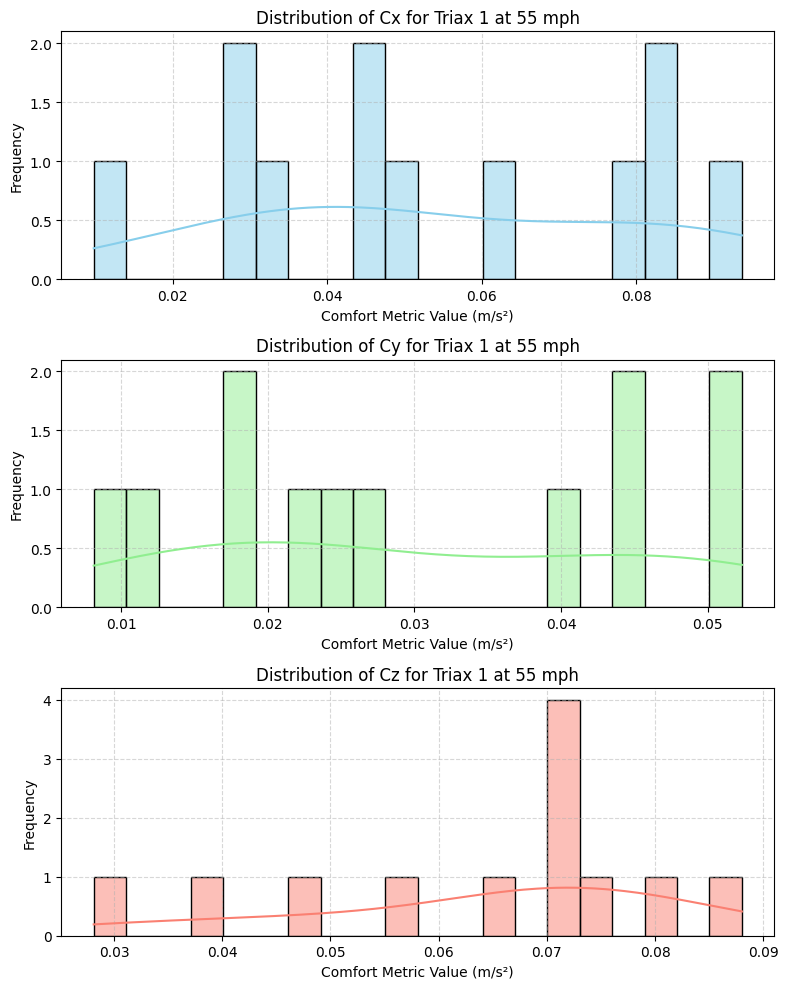

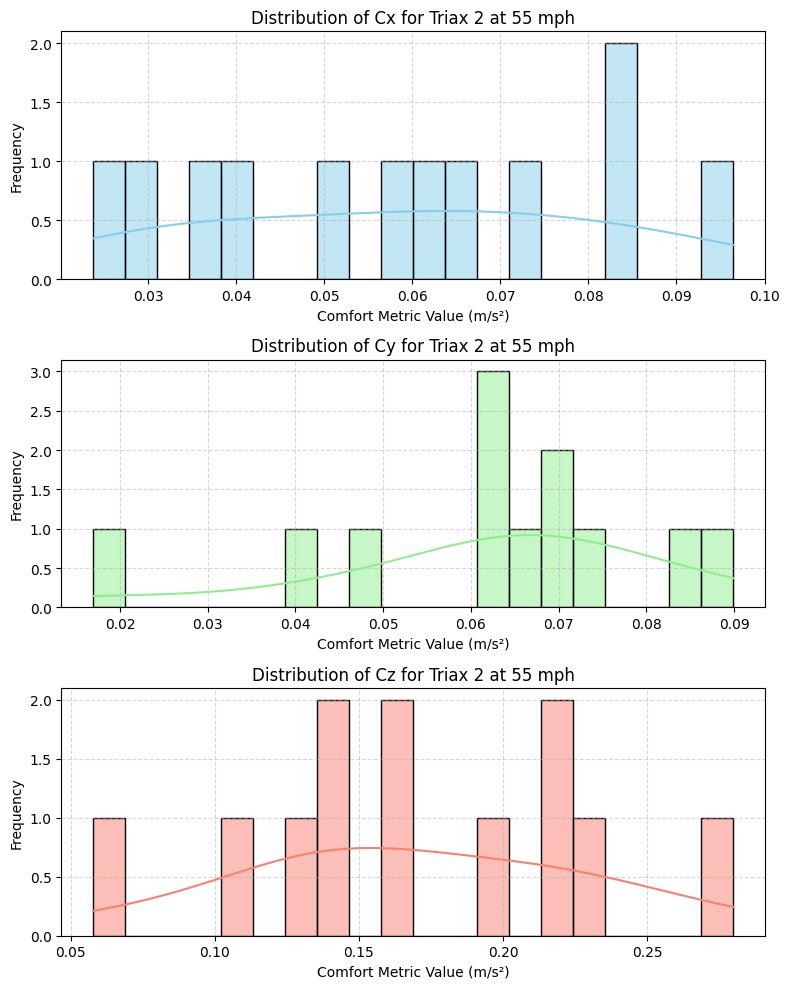

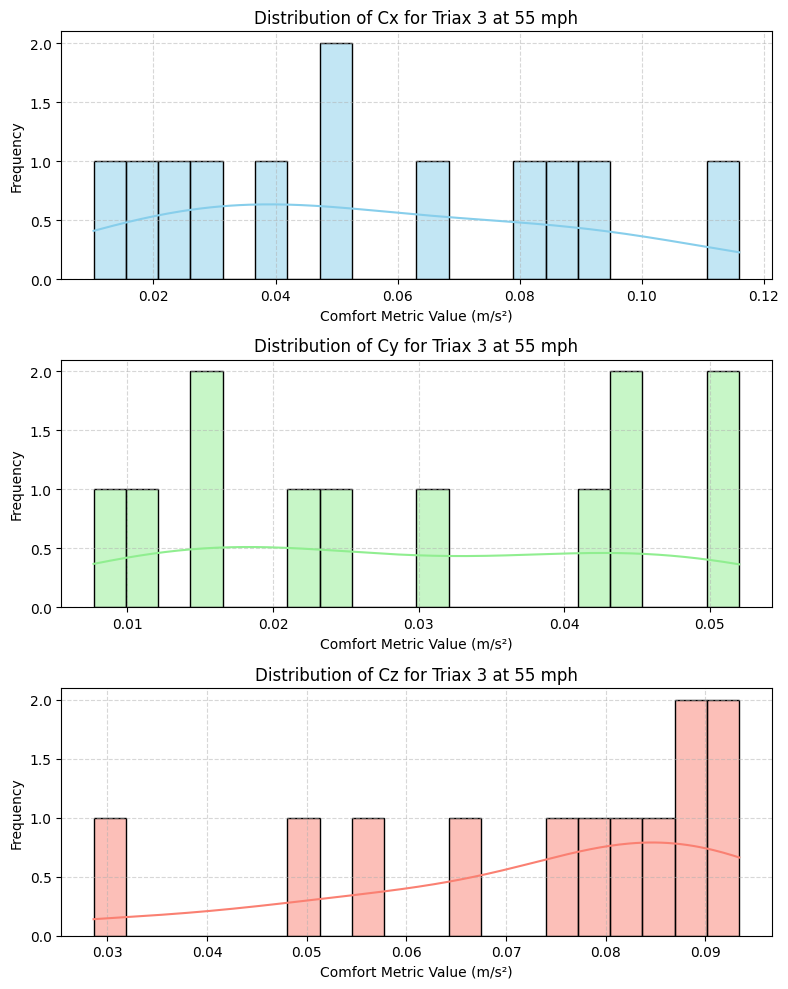

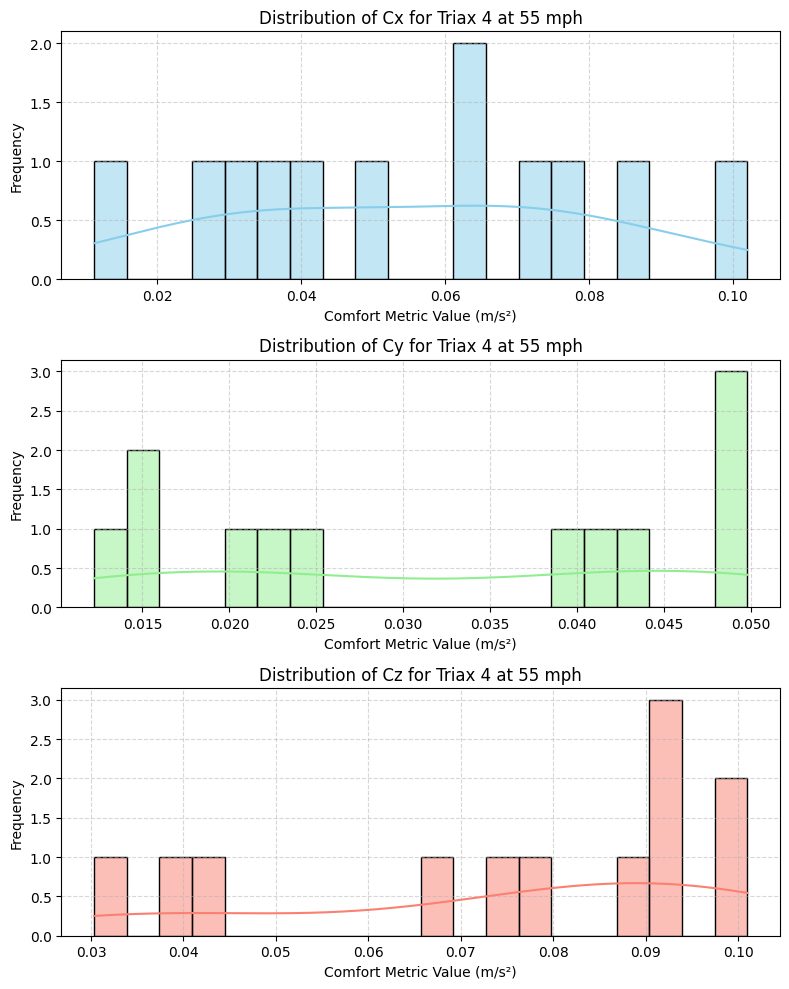

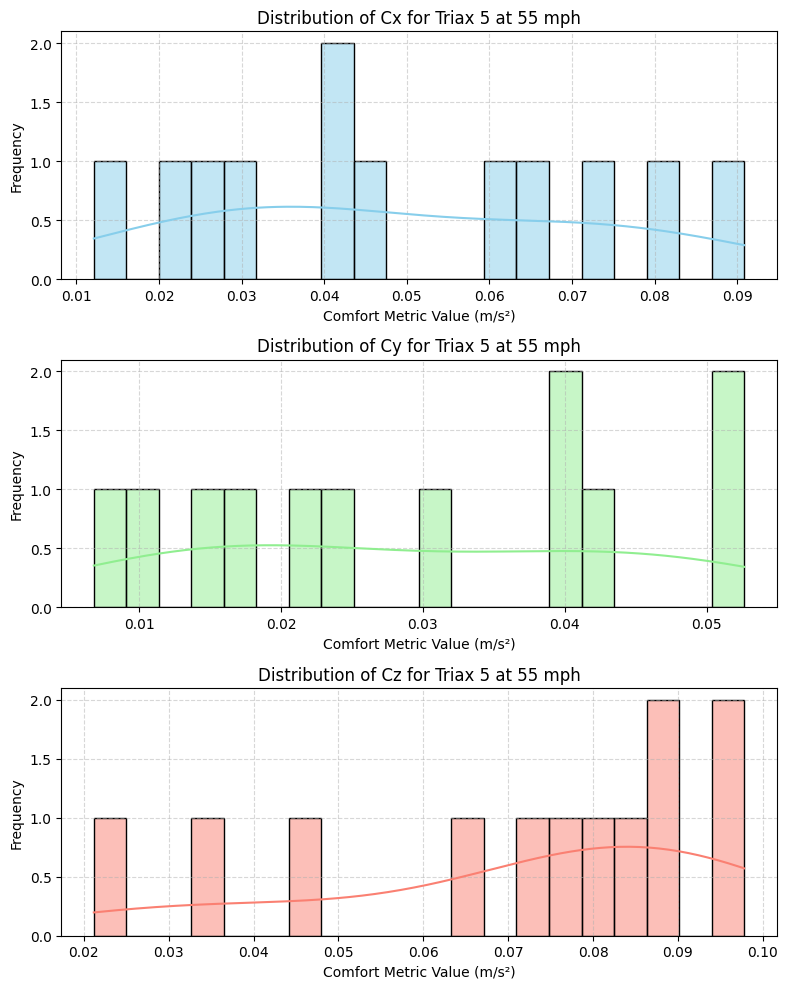

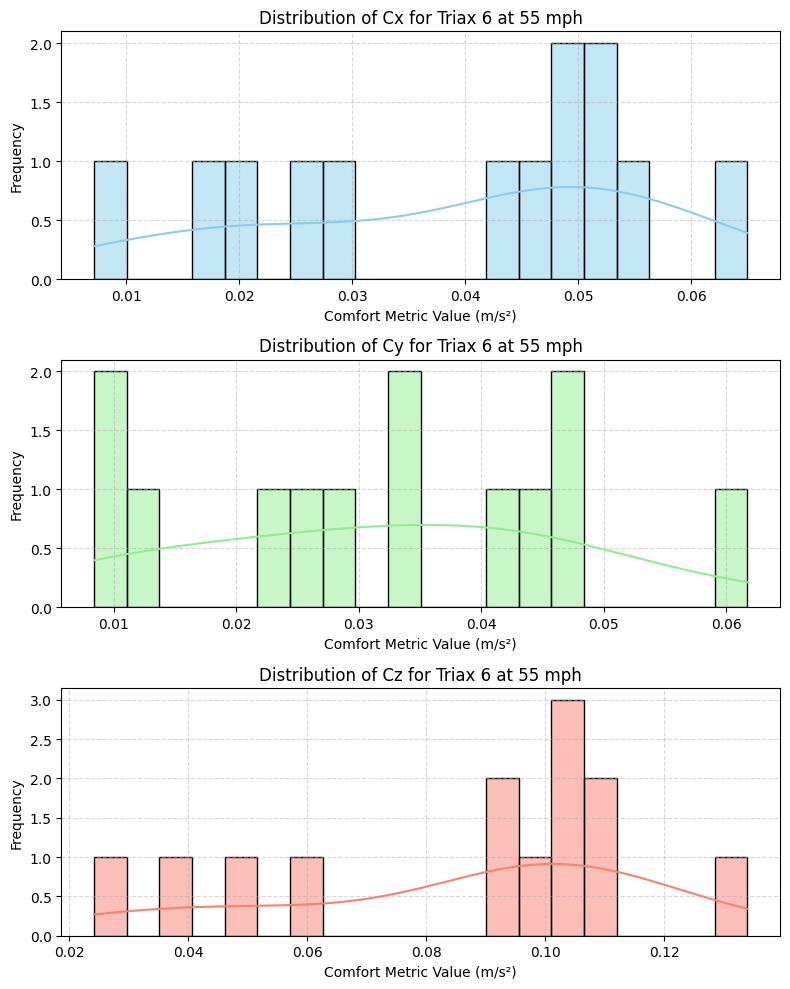

In [7]:
for triax in range(1, 7):
    if triaxes_metrics[str(triax)]["N_MV"] is None:
        continue
    plot_distributions(triaxes_metrics[str(triax)]["Cx"],
                       triaxes_metrics[str(triax)]["Cy"],
                       triaxes_metrics[str(triax)]["Cz"], triax=triax, ride_obj=ride_obj)

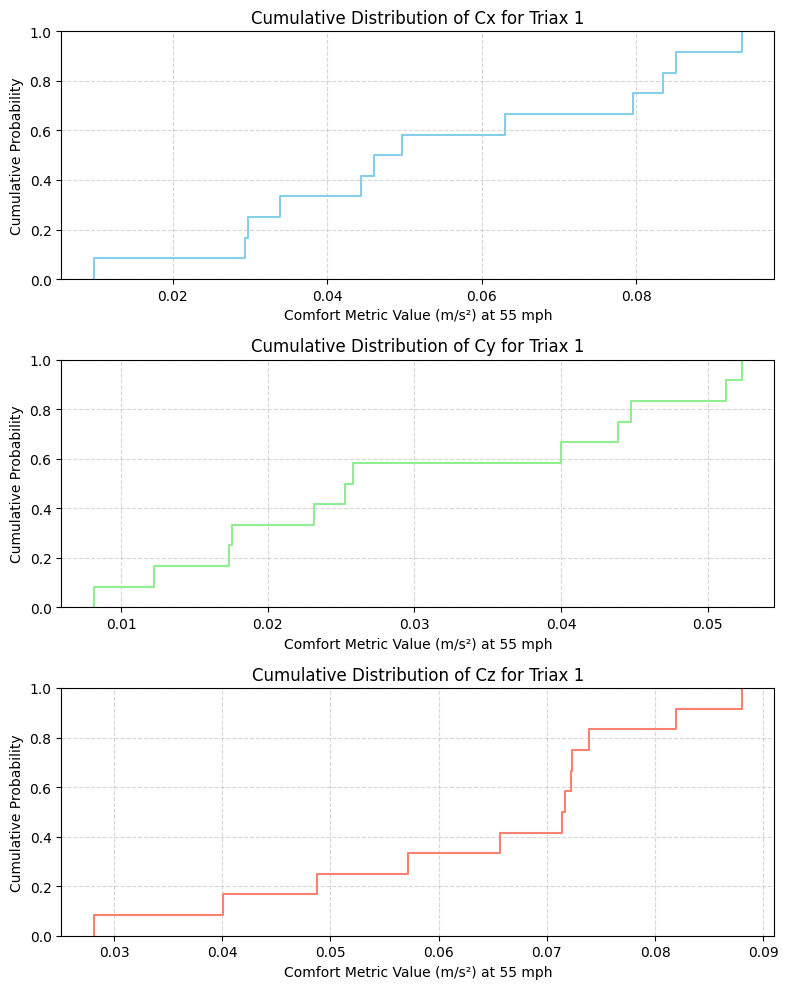

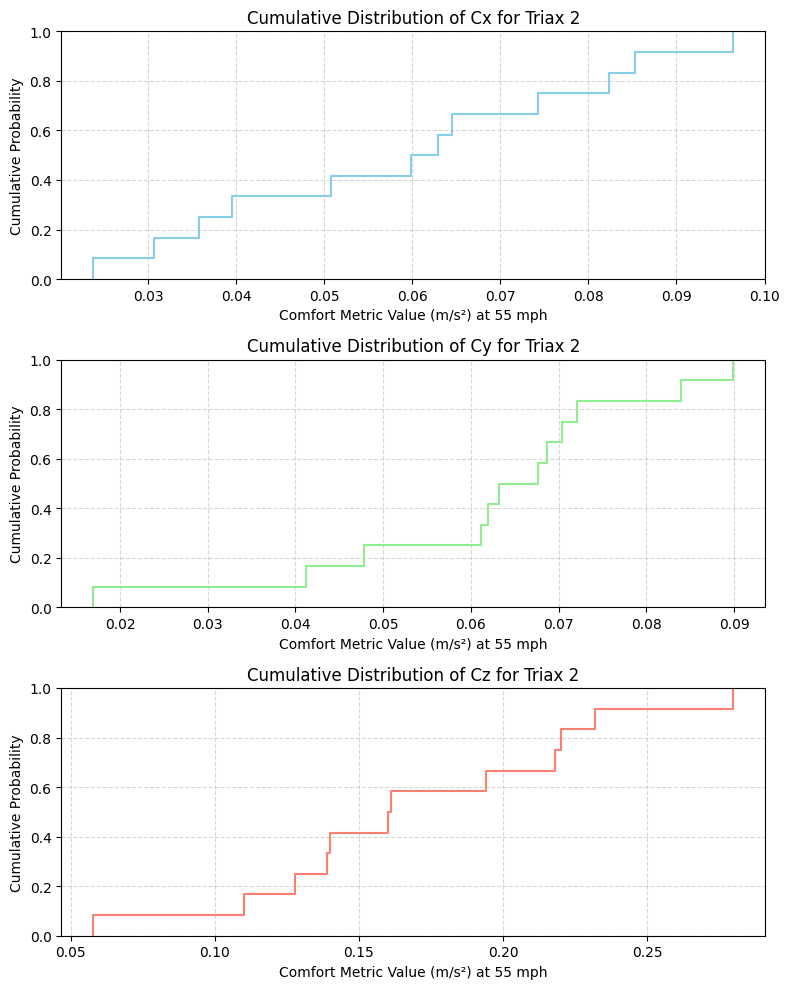

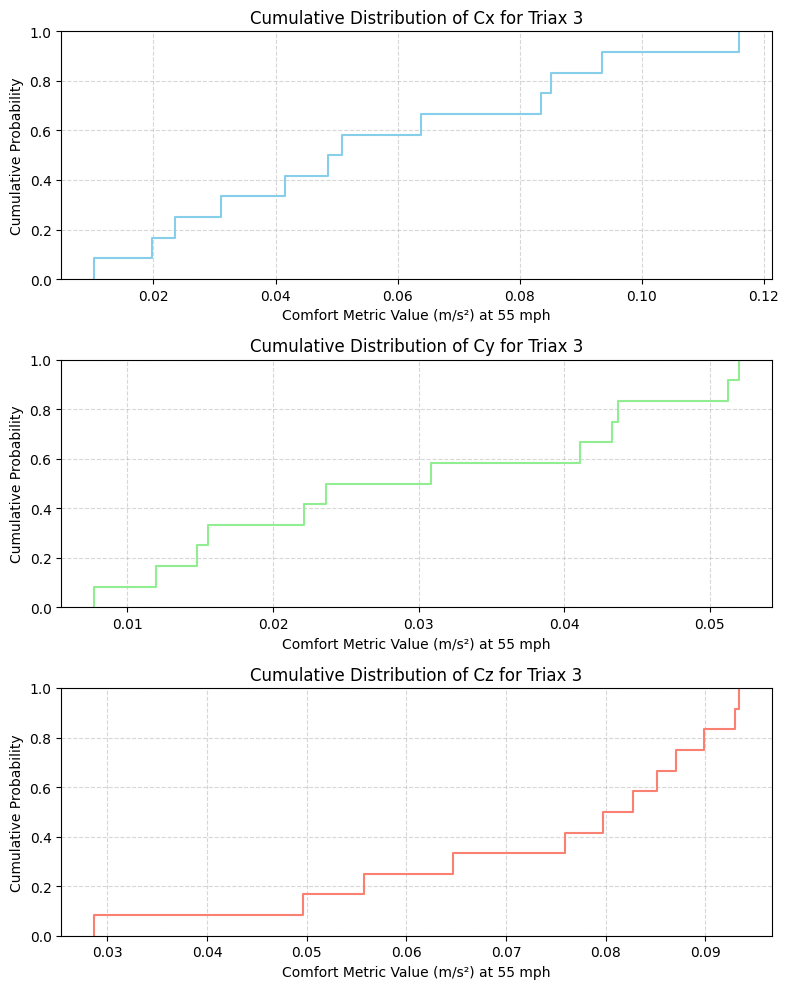

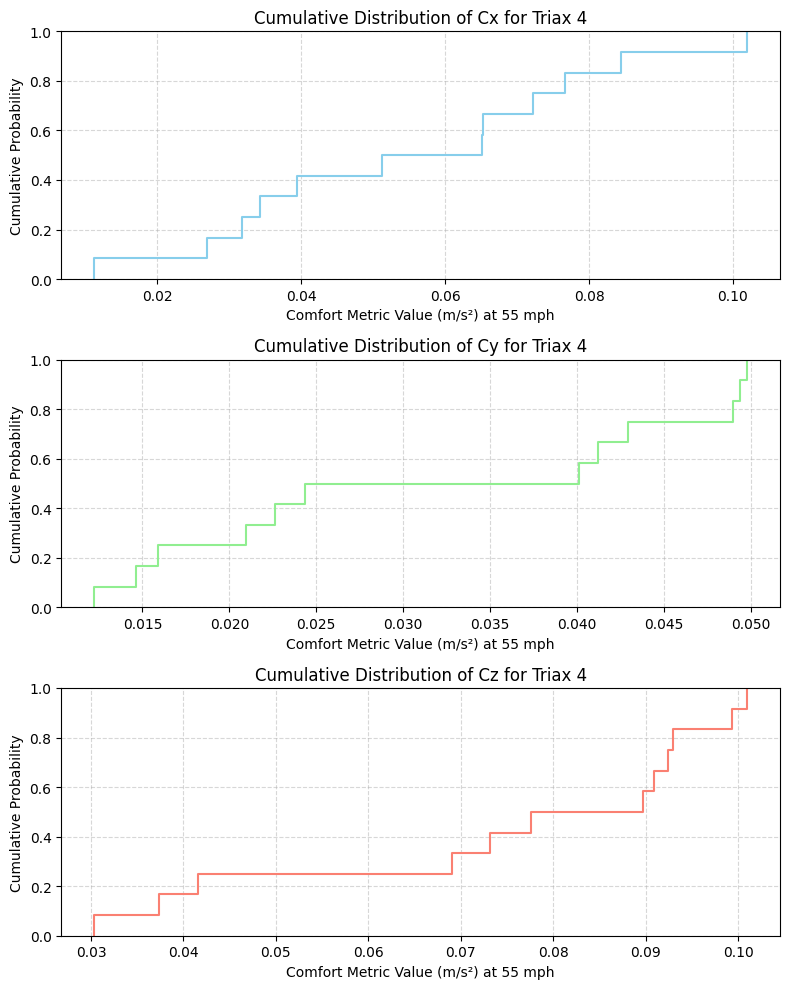

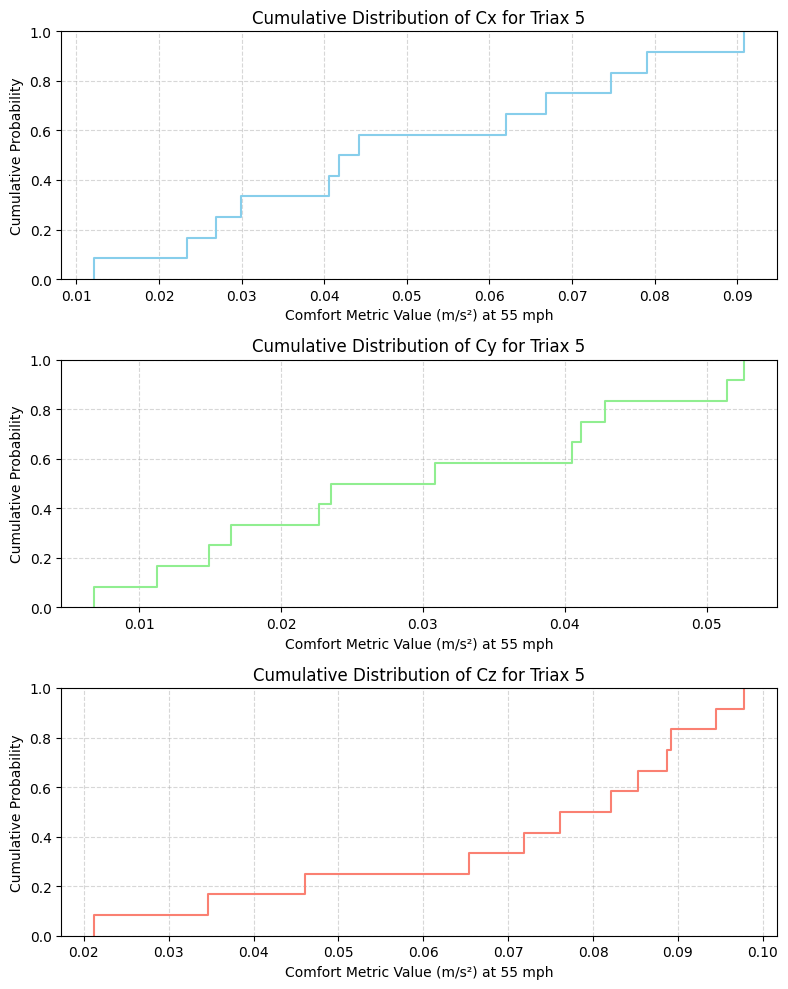

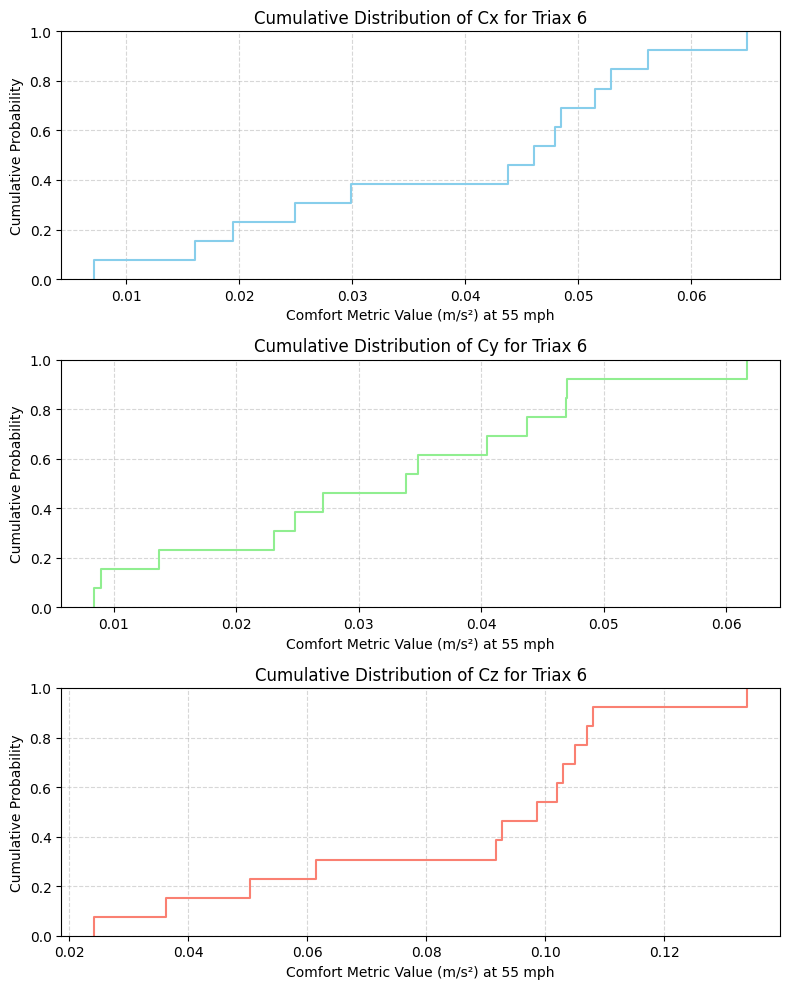

In [8]:
for triax in range(1, 7):
    if triaxes_metrics[str(triax)]["N_MV"] is None:
        continue
    plot_cumulative_distribution(triaxes_metrics[str(triax)]["Cx"],
                       triaxes_metrics[str(triax)]["Cy"],
                       triaxes_metrics[str(triax)]["Cz"], triax=triax, ride_obj=ride_obj)

In [9]:
for (floor, seat), name in pairs:
    floor_curr = rave[str(floor)]
    seat_curr = rave[str(seat)]

    if floor_curr is None or seat_curr is None:
        continue

    
    seat_Cx = triaxes_metrics[str(seat)]["Cx"]
    seat_Cy = triaxes_metrics[str(seat)]["Cy"]
    seat_Cz = triaxes_metrics[str(seat)]["Cz"]

    # Percentile inputs
    seat_Ax95 = np.percentile(seat_Cx, 95)
    seat_Ay95 = np.percentile(seat_Cy, 95)
    seat_Az95 = np.percentile(seat_Cz, 95)

    floor_Cz = triaxes_metrics[str(floor)]["Cz"]
    floor_Azp_95 = np.percentile(floor_Cz, 95)

    NVA = compute_nva(
        floor_Azp_95, seat_Ay95, seat_Az95, seat_Ax95
    )
    triaxes_metrics[str(seat)]["N_VA"] = NVA

    print(f"{name} N_V_A = {NVA:.2f} → {categorize(NVA, categories)}")

Motor Truck N_V_A = 0.84 → Very Comfortable
Between Trucks N_V_A = 1.27 → Very Comfortable
Center Truck N_V_A = 0.98 → Very Comfortable


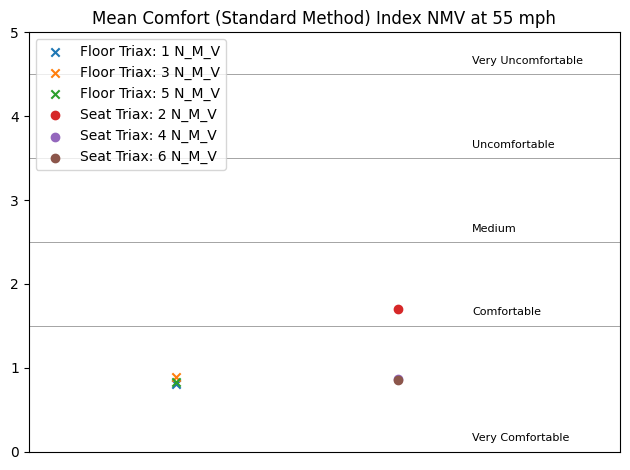

In [10]:
N_MVs = []
for triax in range(1, 7):
    
    N_MV = triaxes_metrics[str(triax)]["N_MV"]

    if N_MV is None:
        continue

    N_MVs.append((triax, N_MV))

plot_comfort_thresholds_nvm(N_MVs, categories, floor_triaxes, ride_obj)

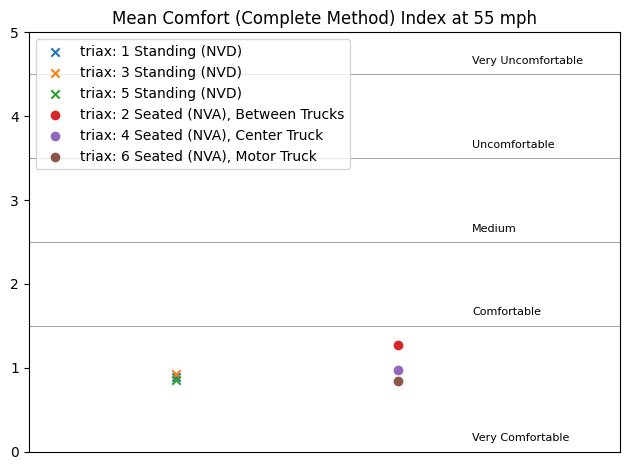

In [11]:
N_VAs = []
N_VDs = []
for triax in range(1, 7):
    N_VD = triaxes_metrics[str(triax)]["N_VD"]
    N_VA = triaxes_metrics[str(triax)]["N_VA"]
    
    N_VDs.append((triax, N_VD))
    N_VAs.append((triax, N_VA))

plot_comfort_thresholds_nvd_nva(N_VDs, N_VAs, categories, pairs, ride_obj)

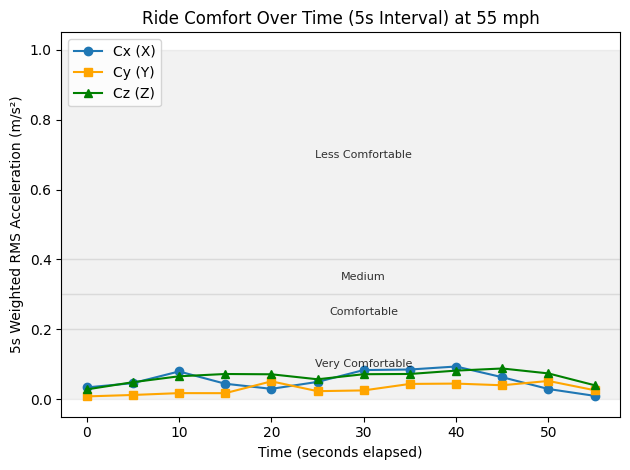

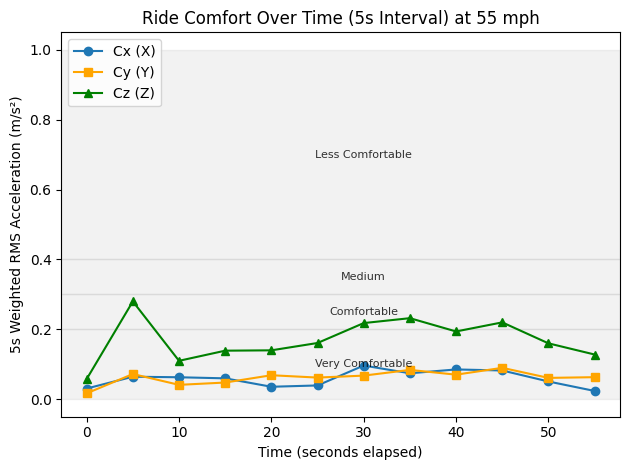

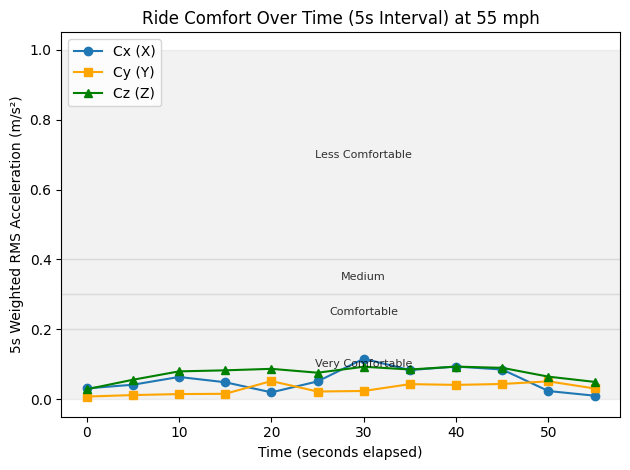

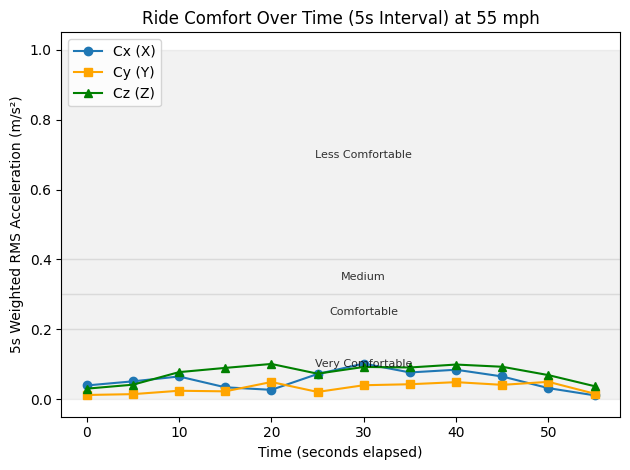

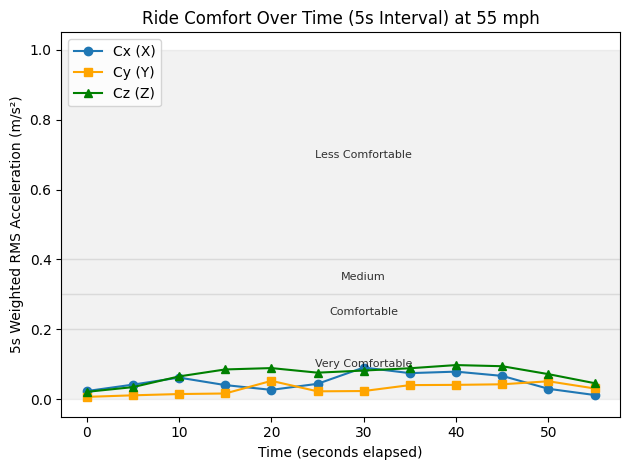

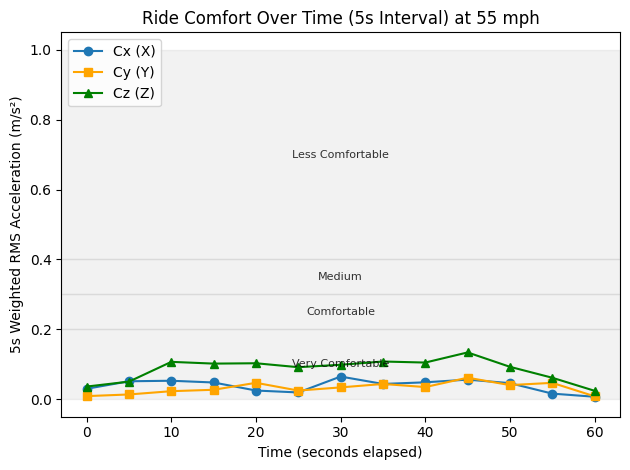

In [12]:
for triax in range(1, 7):
    raw = non_rave[str(triax)]
    
    if raw is None:
        continue

    # Full time vector 
    if triax == 5:
        t_all = pd.to_timedelta(raw["4"]['Number'], unit='s')
    else:
        t_all = pd.to_timedelta(raw["1"]['Number'], unit='s')
    # Downsampled time vector to match 5s interval RAVE slices
    t_5s = t_all[4::5]
    t_5s_minutes = t_5s.dt.total_seconds() / 60
    # 5s signals plot
    Cx, Cy, Cz = triaxes_metrics[str(triax)]["Cx"], triaxes_metrics[str(triax)]["Cy"], triaxes_metrics[str(triax)]["Cz"]
    plot_comfort_timeseries(t_5s_minutes, Cx, Cy, Cz, ride_obj)


In [13]:
#### For av calculation, note that I'm not implementing the kb control flow ###

for triax in range(1, 7):
    raw = non_rave[str(triax)]
    
    if raw is None:
        continue
     
    # Compute AV
    if triax == 5:
        X_ISO = raw["4"]['ISO-WD']
        Y_ISO = raw["5"]['ISO-WD']
        Z_ISO = raw["6"]['ISO-WB']
    else:
        X_ISO = raw["1"]['ISO-WD']
        Y_ISO = raw["2"]['ISO-WD']
        Z_ISO = raw["3"]['ISO-WB']
    
    a_v = compute_av(X_ISO, Y_ISO, Z_ISO)
    triaxes_metrics[str(triax)]["av"] = a_v
    # Compute a_v 
    if triax == 5:
        a_v_5s = compute_av(rave[str(triax)]["4"]['ISO-WD'], rave[str(triax)]["5"]['ISO-WD'], rave[str(triax)]["6"]['ISO-WB'])
    else:
        a_v_5s = compute_av(rave[str(triax)]["1"]['ISO-WD'], rave[str(triax)]["2"]['ISO-WD'], rave[str(triax)]["3"]['ISO-WB'])
    
    triaxes_metrics[str(triax)]["av_5s"] = a_v_5s
    triaxes_metrics[str(triax)]["ax"] = X_ISO
    triaxes_metrics[str(triax)]["ay"] = Y_ISO
    triaxes_metrics[str(triax)]["az"] = Z_ISO
    triaxes_metrics[str(triax)]["max_ax"] = X_ISO.max()
    triaxes_metrics[str(triax)]["max_ay"] = Y_ISO.max()
    triaxes_metrics[str(triax)]["max_az"] = Z_ISO.max()
    triaxes_metrics[str(triax)]["max_av"] = a_v.max()
    triaxes_metrics[str(triax)]["max_av_5s"] = a_v_5s.max()

    print(f"triax:{triax} a_v (1s ISO composite) = {np.mean(a_v):.3f} m/s²")
    print(f"triax:{triax}  a_v_5s (from RAVE)      = {np.mean(a_v_5s):.3f} m/s²")



triax:1 a_v (1s ISO composite) = 0.085 m/s²
triax:1  a_v_5s (from RAVE)      = 0.087 m/s²
triax:2 a_v (1s ISO composite) = 0.178 m/s²
triax:2  a_v_5s (from RAVE)      = 0.184 m/s²
triax:3 a_v (1s ISO composite) = 0.095 m/s²
triax:3  a_v_5s (from RAVE)      = 0.096 m/s²
triax:4 a_v (1s ISO composite) = 0.096 m/s²
triax:4  a_v_5s (from RAVE)      = 0.098 m/s²
triax:5 a_v (1s ISO composite) = 0.087 m/s²
triax:5  a_v_5s (from RAVE)      = 0.088 m/s²
triax:6 a_v (1s ISO composite) = 0.101 m/s²
triax:6  a_v_5s (from RAVE)      = 0.102 m/s²


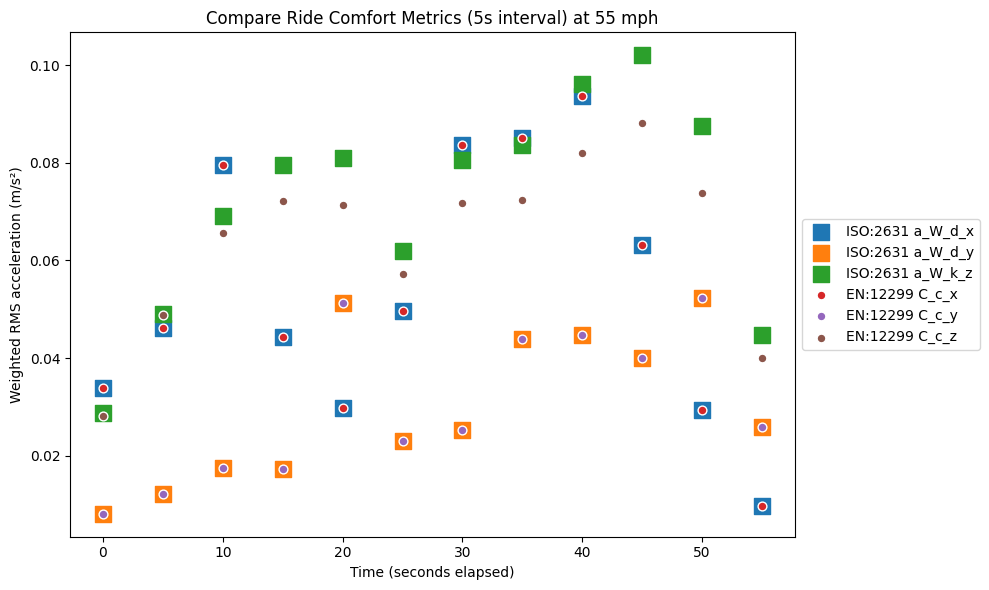

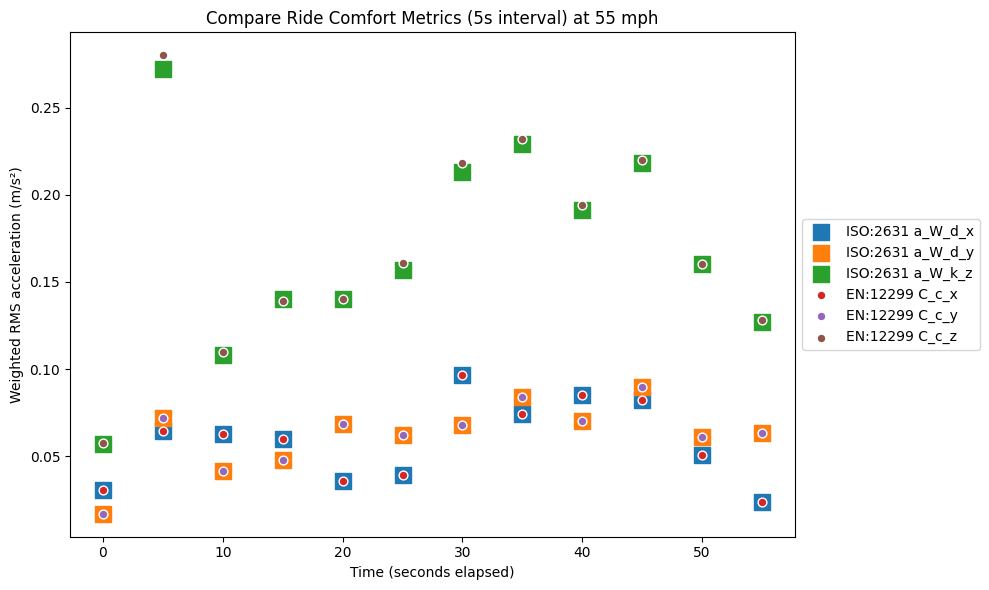

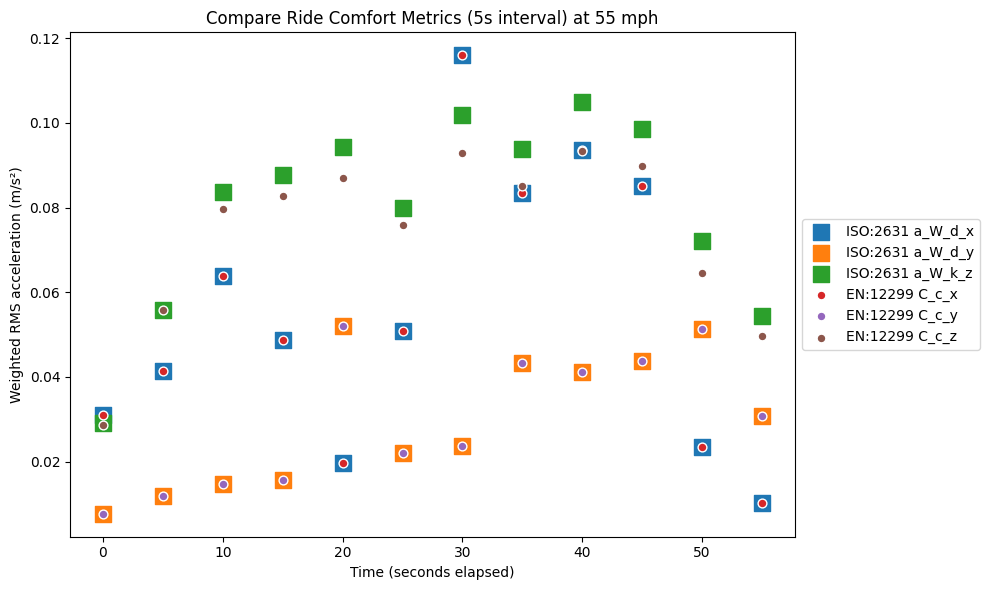

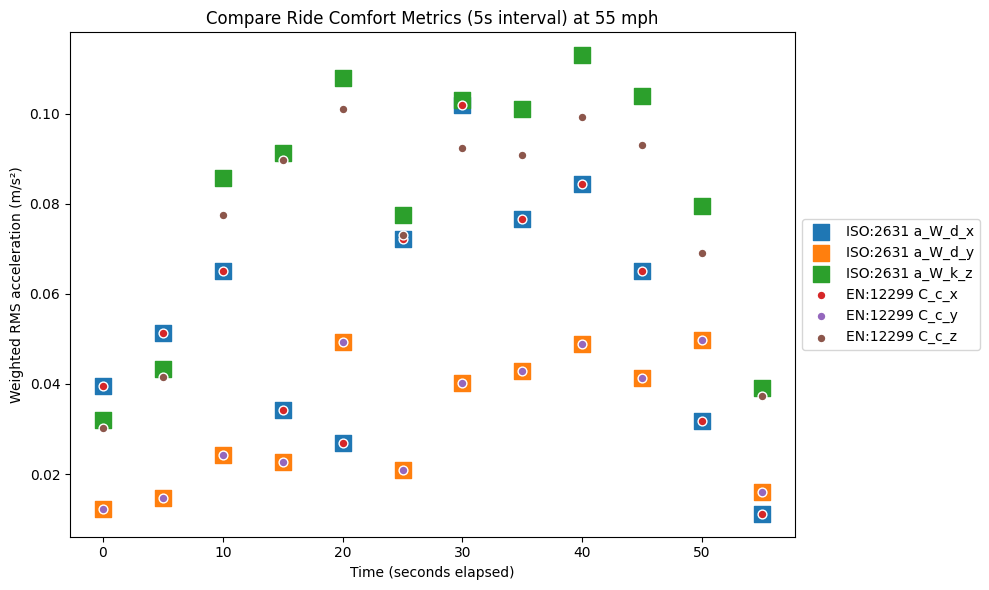

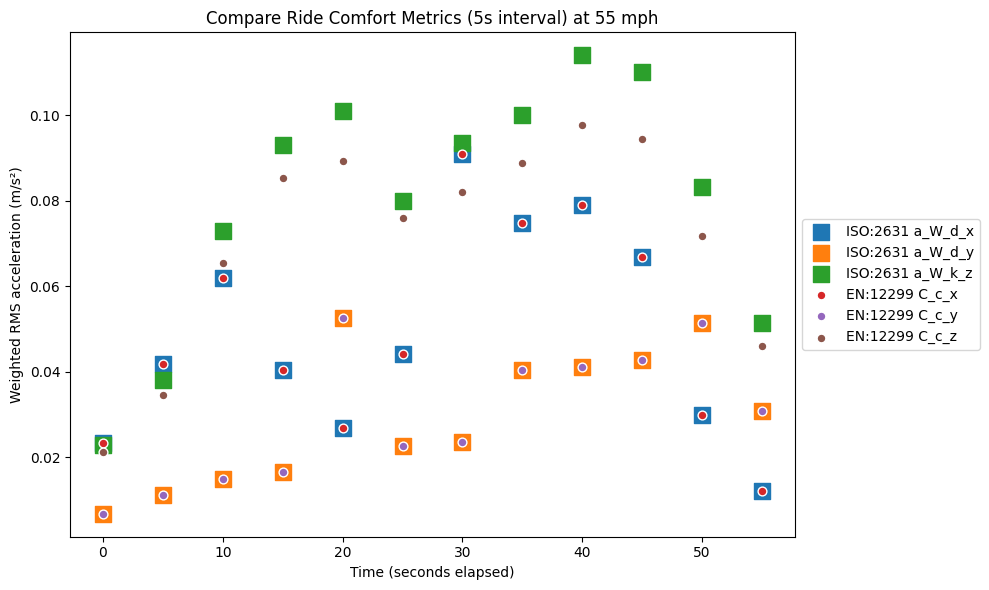

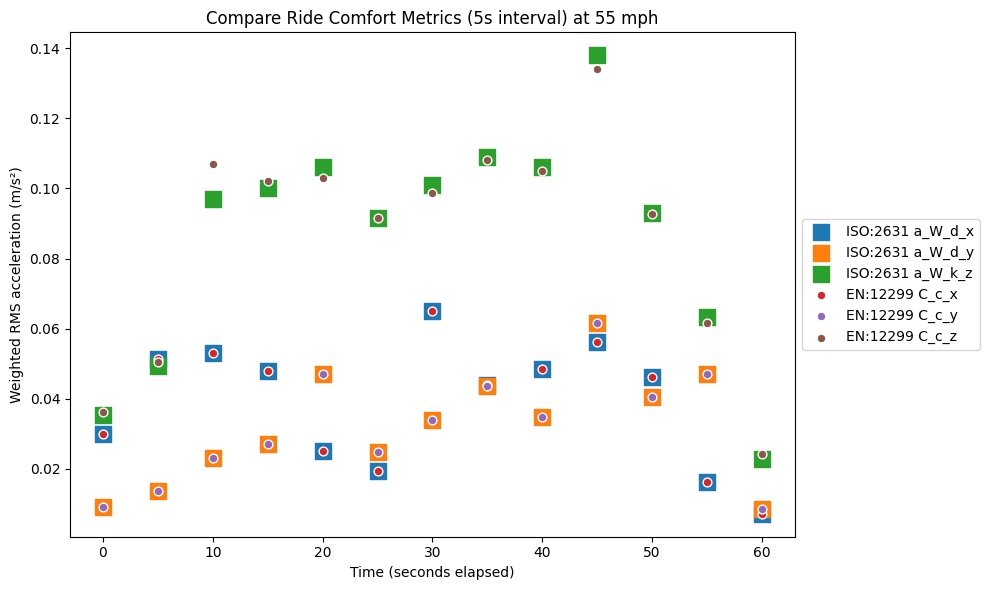

In [14]:
for triax in range(1, 7):
    rave_curr = rave[str(triax)]
    raw = non_rave[str(triax)]

    if raw is None or rave_curr is None:
        continue

    if triax == 5:
        t_5s_minutes = pd.to_timedelta(raw["4"]['Number'], unit='s')[4::5].dt.total_seconds() / 60

        x5 = rave_curr["4"]['ISO-WD'].iloc[4::5]
        y5 = rave_curr["5"]['ISO-WD'].iloc[4::5]
        z5 = rave_curr["6"]['ISO-WK'].iloc[4::5]
    else:
        t_5s_minutes = pd.to_timedelta(raw["1"]['Number'], unit='s')[4::5].dt.total_seconds() / 60

        x5 = rave_curr["1"]['ISO-WD'].iloc[4::5]
        y5 = rave_curr["2"]['ISO-WD'].iloc[4::5]
        z5 = rave_curr["3"]['ISO-WK'].iloc[4::5]
    
    plot_compare_all_metrics(
        t_5s_minutes,
        x5,
        y5,
        z5,
        triaxes_metrics[str(triax)]["Cx"], triaxes_metrics[str(triax)]["Cy"], triaxes_metrics[str(triax)]["Cz"], ride_obj
    )


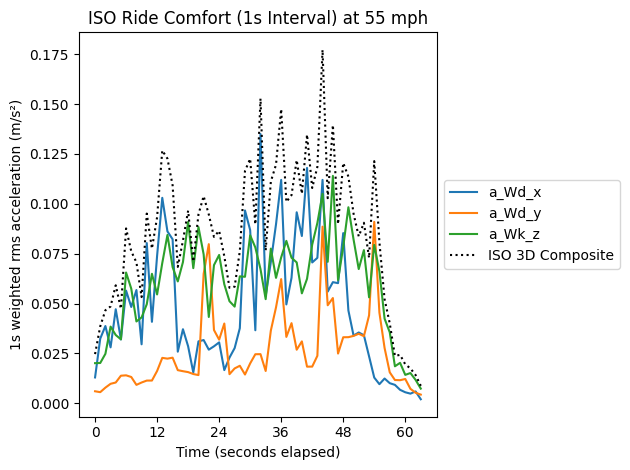

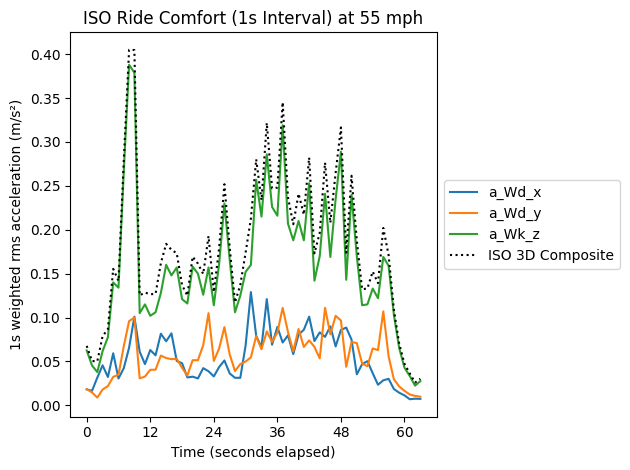

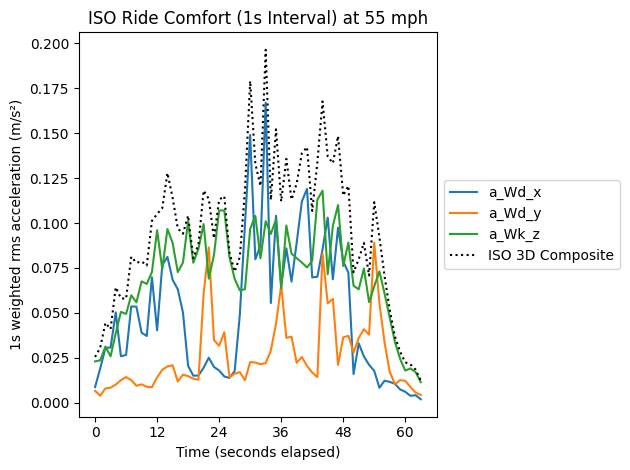

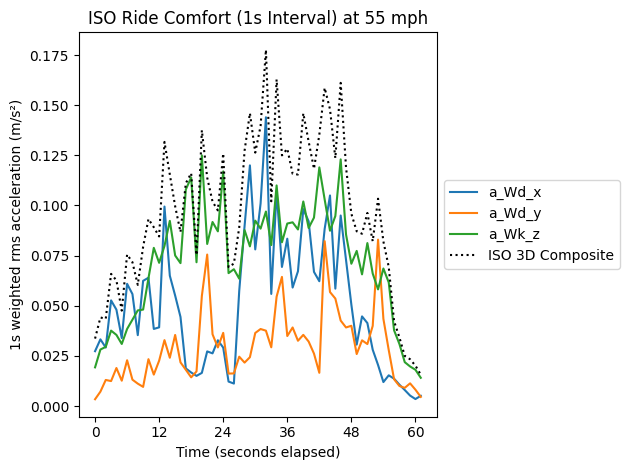

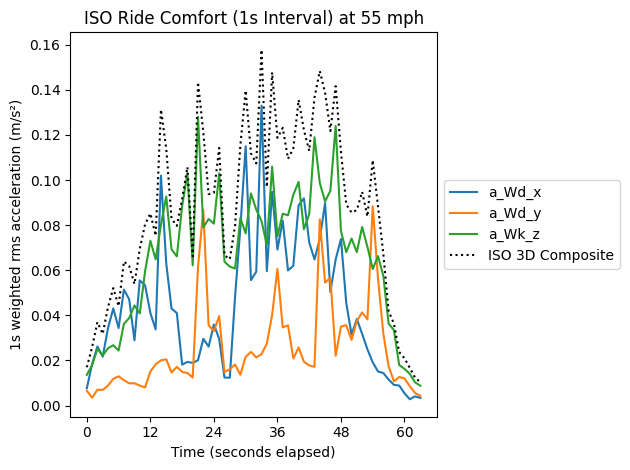

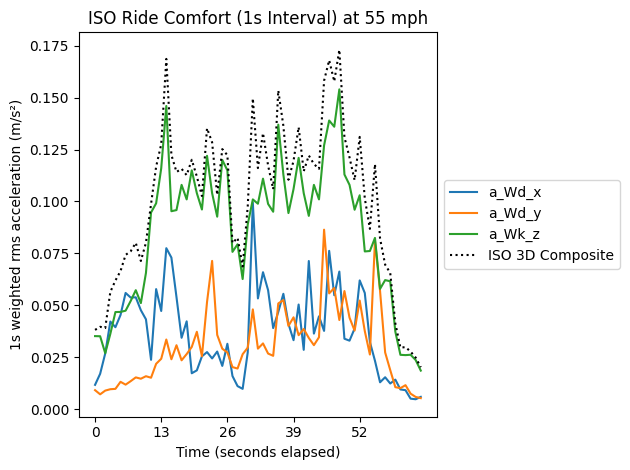

In [15]:
for triax in range(1, 7):
    raw = non_rave[str(triax)]

    if raw is None:
        continue
    
    if triax == 5:
        t_all = pd.to_timedelta(raw["4"]['Number'], unit='s')
        t_5s_minutes = pd.to_timedelta(raw["4"]['Number'], unit='s')[4::5].dt.total_seconds() / 60
        X_ISO = raw["4"]['ISO-WD']
        Y_ISO = raw["5"]['ISO-WD']
        Z_ISO = raw["6"]['ISO-WB']

    else:
        t_all = pd.to_timedelta(raw["1"]['Number'], unit='s')
        t_5s_minutes = pd.to_timedelta(raw["1"]['Number'], unit='s')[4::5].dt.total_seconds() / 60
        X_ISO = raw["1"]['ISO-WD']
        Y_ISO = raw["2"]['ISO-WD']
        Z_ISO = raw["3"]['ISO-WB']
    a_v = triaxes_metrics[str(triax)]["av"]
    a_v_5s = triaxes_metrics[str(triax)]["av_5s"]

    plot_iso_timeseries(t_all, X_ISO, Y_ISO, Z_ISO, a_v, ride_obj)

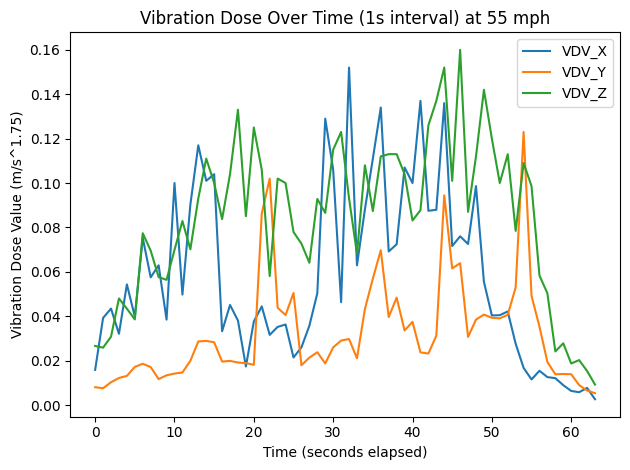

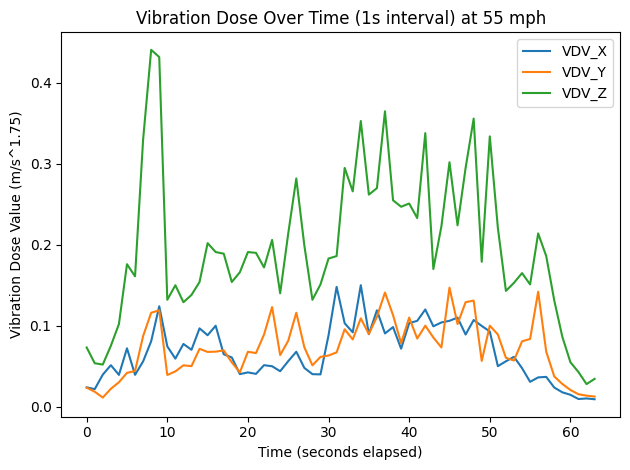

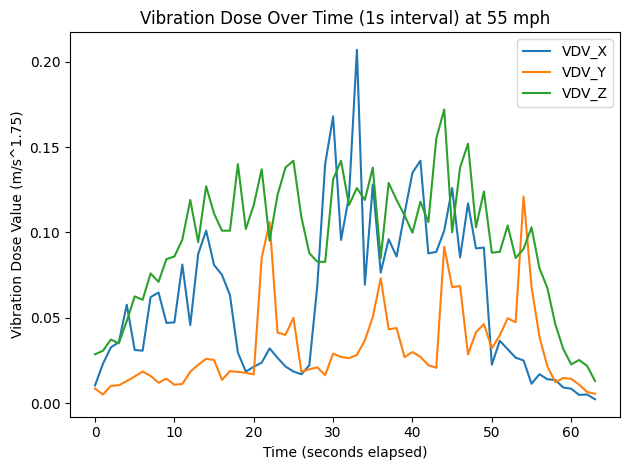

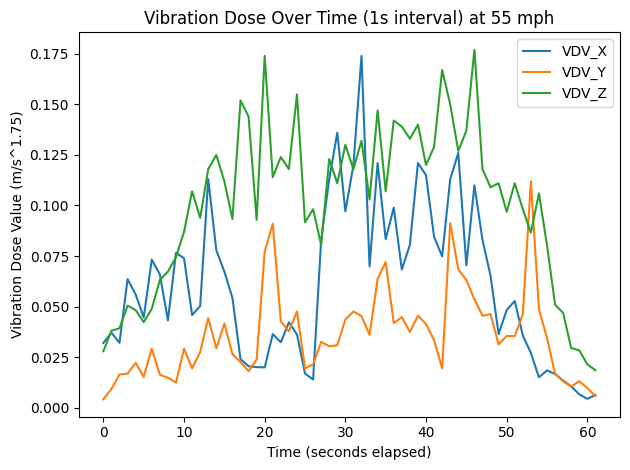

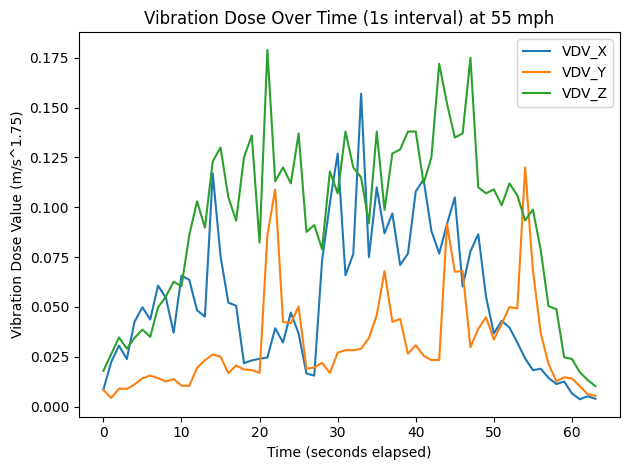

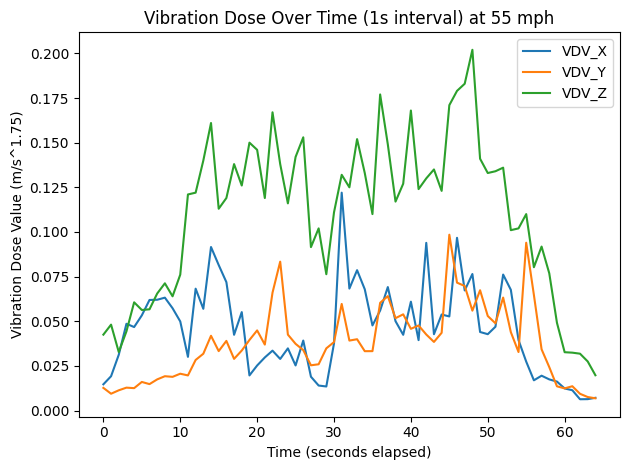

In [16]:
for triax in range(1, 7):
    raw = non_rave[str(triax)]
    
    if raw is None:
        continue
    
    if triax == 5:
        t_all = pd.to_timedelta(raw["4"]['Number'], unit='s')
        X_VDV = raw["4"]['WD4th_VDV']
        Y_VDV = raw["5"]['WD4th_VDV']
        Z_VDV = raw["6"]['WK4th_VDV']

    else:
        t_all = pd.to_timedelta(raw["1"]['Number'], unit='s')
        # VDV data
        X_VDV = raw["1"]['WD4th_VDV']
        Y_VDV = raw["2"]['WD4th_VDV']
        Z_VDV = raw["3"]['WK4th_VDV']
        
    plot_vdv_over_time(t_all, X_VDV, Y_VDV, Z_VDV, ride_obj)

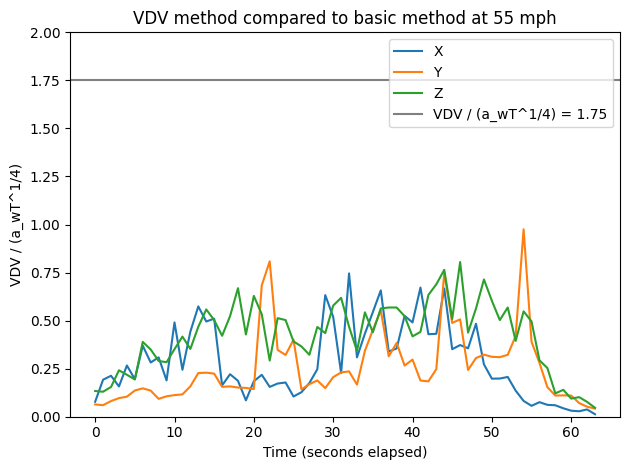

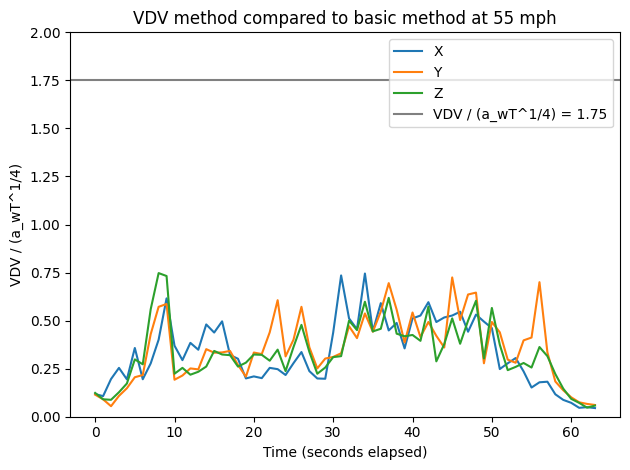

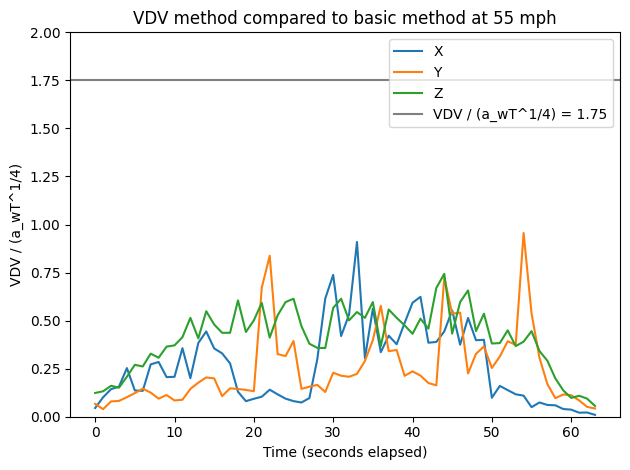

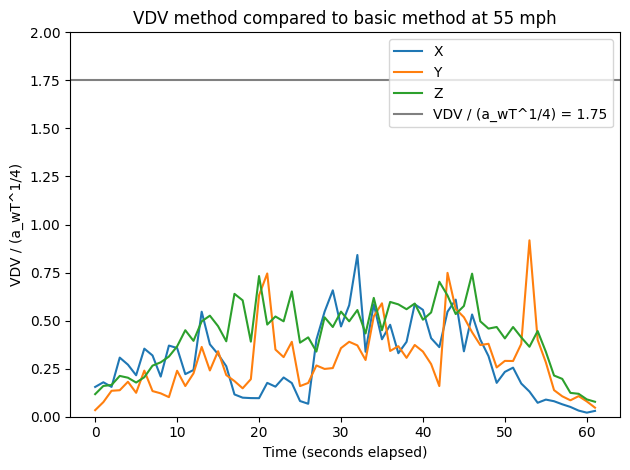

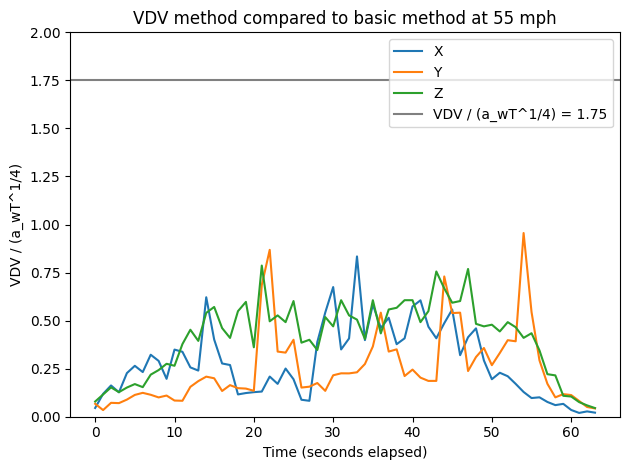

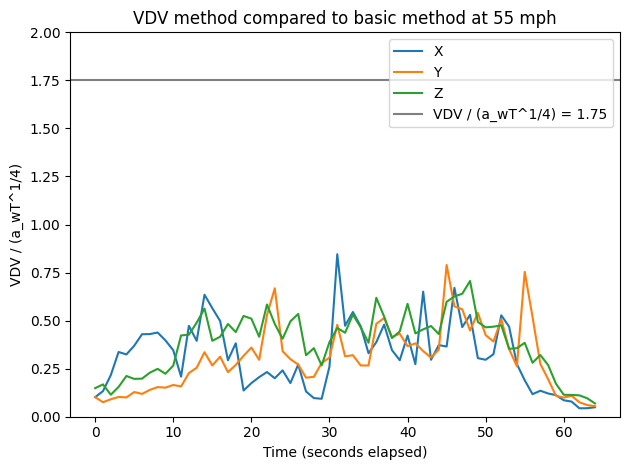

In [17]:
for triax in range(1, 7):
    raw = non_rave[str(triax)]

    if raw is None:
        continue
    
    if triax == 5:
        t_all = pd.to_timedelta(raw["4"]['Number'], unit='s')
        X_VDV = raw["4"]['WD4th_VDV']
        Y_VDV = raw["5"]['WD4th_VDV']
        Z_VDV = raw["6"]['WK4th_VDV']
        X_ISO = raw["4"]['ISO-WD']
        Y_ISO = raw["5"]['ISO-WD']
        Z_ISO = raw["6"]['ISO-WB']

    else:
        t_all = pd.to_timedelta(raw["1"]['Number'], unit='s')
        # VDV data
        X_VDV = raw["1"]['WD4th_VDV']
        Y_VDV = raw["2"]['WD4th_VDV']
        Z_VDV = raw["3"]['WK4th_VDV']
        X_ISO = raw["1"]['ISO-WD']
        Y_ISO = raw["2"]['ISO-WD']
        Z_ISO = raw["3"]['ISO-WB']

    ratios = [
        compute_vdv_ratios(X_VDV, compute_vdv(X_ISO)),
        compute_vdv_ratios(Y_VDV, compute_vdv(Y_ISO)),
        compute_vdv_ratios(Z_VDV, compute_vdv(Z_ISO))
    ]
    plot_ratio_comparison(t_all, ratios, labels=['X', 'Y', 'Z'], ride_obj=ride_obj)

In [18]:
ride_obj.metrics = triaxes_metrics
ride_obj.save_to_json("data/ride_metrics.json")

In [26]:

ride_load = Ride.load_json("data/ride_metrics.json")


In [28]:
ride_load.metrics

{'1': {'N_MV': 0.7997715726831005,
  'N_VD': 0.89090368149112,
  'N_VA': None,
  'Cx': 4     0.033820
  9     0.046120
  14    0.079570
  19    0.044400
  24    0.029780
  29    0.049640
  34    0.083540
  39    0.085130
  44    0.093710
  49    0.063060
  54    0.029290
  59    0.009748
  Name: ISO-WD, dtype: float64,
  'Cy': 4     0.008129
  9     0.012260
  14    0.017530
  19    0.017390
  24    0.051240
  29    0.023130
  34    0.025290
  39    0.043870
  44    0.044810
  49    0.040020
  54    0.052340
  59    0.025830
  Name: ISO-WD, dtype: float64,
  'Cz': 4     0.02811
  9     0.04880
  14    0.06571
  19    0.07225
  24    0.07144
  29    0.05714
  34    0.07166
  39    0.07234
  44    0.08195
  49    0.08803
  54    0.07390
  59    0.04008
  Name: EN-WB, dtype: float64,
  'Cx_mean': 0.053984,
  'Cx_std': 0.02564242323442411,
  'Cy_mean': 0.030153250000000003,
  'Cy_std': 0.014878328519051905,
  'Cz_mean': 0.06428416666666666,
  'Cz_std': 0.016806779117533362,
  'max_Cx': 0.0